# Bank Score: Credit Approval Through Neural Networks

We aim to develop a testing protocol that allows finding the best fully connected neural network architecture. We will use the SciKit-Learn library (sklearn.neural_network) to design each network. Additionally, we will explore some concepts of feature engineering to analyze the available data.

In [79]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

Two files are available:

`application_record.csv`: It contains general information (you can observe the column names below) about each user, defined from a unique ID.

- ID: client number
- CODE_GENDER: gender
- FLAG_OWN_CAR: owns a car
- FLAG_OWN_REALTY: owns real estate
- CNT_CHILDREN: number of children
- AMT_INCOME_TOTAL: annual income
- NAME_INCOME_TYPE: income category
- NAME_EDUCATION_TYPE: educational level
- NAME_FAMILY_STATUS: marital status
- NAME_HOUSING_TYPE: housing type (e.g., rent, own apartment, ...)
- DAYS_BIRTH: date of birth, in days backwards from today, -1 means yesterday
- DAYS_EMPLOYED: employment time, in days backwards from today, -1 means yesterday. If positive, the user is unemployed.
- FLAG_MOBIL: mobile phone
- FLAG_WORK_PHONE: work phone
- FLAG_PHONE: phone
- FLAG_EMAIL: email
- OCCUPATION_TYPE: occupation
- CNT_FAM_MEMBERS: family size

`credit_record.csv`:

- ID: client number
- MONTHS_BALANCE: registration month
- STATUS:
    - 0: 1-29 days overdue
    - 1: 30-59 days overdue
    - 2: 60-89 days overdue
    - 3: 90-119 days overdue
    - 4: 120-149 days overdue
    - 5: Overdue or bad debts, cancellations for more than 150 days
    - C: Canceled that month X: No loan during the month


In [80]:
data = pd.read_csv("creditCardScore/application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("creditCardScore/credit_record.csv", encoding = 'utf-8')

In [81]:
plt.rcParams['figure.facecolor'] = 'white'

In [82]:
data.tail()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0
438556,6842885,F,N,Y,0,121500.0,Working,Secondary / secondary special,Married,House / apartment,-18858,-1201,1,0,1,0,Sales staff,2.0


In [83]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## Data Preparation

### Labels

Initially, both tables are concatenated using the maximum registration time (`MONTHS_BALANCE`) and the client's ID.

In [84]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

Users with overdue for more than 60 days will be labeled as `1`, otherwise, they will be `0`.

In [85]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

In [86]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [87]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

dep_value
No     45318
Yes      667
Name: count, dtype: int64


dep_value
No     0.985495
Yes    0.014505
Name: proportion, dtype: float64

Class Proportion.

### Descriptors

+ Rename Columns

In [88]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [89]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna() # Retiramos los valores NaN

In [90]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

### Funciones Auxiliares

Below are some functions that will be used later.

Function `calc_iv` to obtain the IV (information value) and WoE (weight of evidence) variables. These variables, in general, allow us to know the importance of each available feature.

You can find more information at:
- https://www.kaggle.com/puremath86/iv-woe-starter-for-python
- https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

In [91]:
# Cálculo de IV
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print(f"This variable's IV is: {iv}")
    print(df[feature].value_counts())
    return iv, data

In [92]:
# One-Hot Encoding
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [93]:
def get_category(df, col, binsnum, labels, qcut = False):

    # Handle NaN values
    df[col] = df[col].fillna("NULL")

    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [94]:
# Matriz de Confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label')
    plt.xlabel('Prediction')

### Binary Descriptors

The previously developed function will be used to analyze each of the binary descriptors and **their influence within the prediction of each class**.

#### Gender


In [95]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

Gender
0    15630
1     9504
Name: count, dtype: int64
This variable's IV is: 0.02520350452745081
Gender
0    15630
1     9504
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


#### Car Ownership

In [96]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

Car
0    14618
1    10516
Name: count, dtype: int64
This variable's IV is: 4.54248124999671e-06
Car
0    14618
1    10516
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


#### Real Estate Ownership

In [97]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

Reality
1    16461
0     8673
Name: count, dtype: int64
This variable's IV is: 0.02744070350168343
Reality
1    16461
0     8673
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


#### Phone Ownership

In [98]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

phone
0    0.707209
1    0.292791
Name: proportion, dtype: float64
This variable's IV is: 0.0005480495762639297
phone
0    17775
1     7359
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


#### Email Ownership

In [99]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

email
0    0.89934
1    0.10066
Name: proportion, dtype: float64
This variable's IV is: 1.7343581493999816e-05
email
0    22604
1     2530
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


#### Worh phone Ownership

In [100]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

This variable's IV is: 0.002042429795148461
wkphone
0    18252
1     6882
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


### Continuous Descriptors

#### Quantity of Children

In [101]:
# Separamos aquellos que: no tienen hijos, tienen 1 hijo, tienen 2 o más hijos.

new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

ChldNo
0        15908
2More     3108
1         6118
Name: count, dtype: int64


In [102]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

This variable's IV is: 0.0011214542503301935
ChldNo
0        15908
1         6118
2More     3108
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [103]:
new_data = convert_dummy(new_data,'ChldNo') # Adicionamos una Codificación One-Hot

In [104]:
new_data.head()

,ID,Gender,Car,Reality,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,...,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target,ChldNo_1,ChldNo_2More
2,5008806,1,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,...,0,0,0,Security staff,2.0,-29.0,No,0,False,False
3,5008808,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-4.0,No,0,False,False
4,5008809,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-26.0,No,0,False,False
5,5008810,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-26.0,No,0,False,False
6,5008811,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,-38.0,No,0,False,False


#### Annual Income

Histogram Plot to observe the distribution.


In [105]:
new_data['inc'] = new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: count, dtype: int64


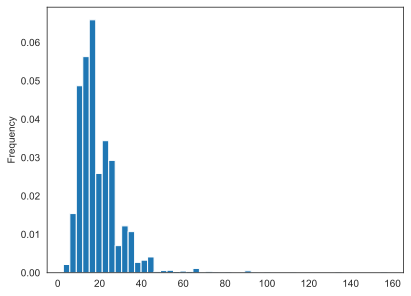

In [106]:
new_data['inc'].plot(kind='hist',bins=50,density=True)
plt.show()

In [107]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut=True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

This variable's IV is: 0.0024219962221596752
gp_inc
low       8996
high      8244
medium    7894
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_inc,high,8244,8096,148,0.328002,0.017952,0.327614,0.350711,-0.068126,0.001573
1,gp_inc,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,gp_inc,medium,7894,7767,127,0.314077,0.016088,0.314301,0.300948,0.043413,0.000580


In [108]:
new_data = convert_dummy(new_data,'gp_inc')

#### Age

In [109]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: proportion, dtype: float64


<Axes: ylabel='Frequency'>

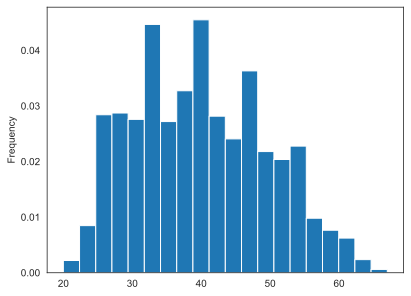

In [110]:
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [111]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.06593513858884348
gp_Age
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [112]:
new_data = convert_dummy(new_data,'gp_Age')

#### Work Time

In [113]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean

<Axes: ylabel='Frequency'>

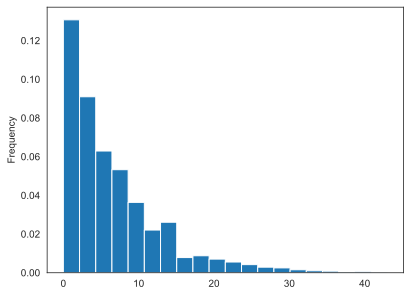

In [114]:
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [115]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

This variable's IV is: 0.04022152230816303
gp_worktm
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [116]:
# One-Hot Encoding
new_data = convert_dummy(new_data,'gp_worktm')

#### Family Size

In [117]:
new_data['famsize'].value_counts(sort=False)

famsize
2.0     12697
1.0      4263
5.0       307
3.0      5216
4.0      2576
6.0        51
15.0        3
7.0        18
20.0        1
9.0         2
Name: count, dtype: int64

In [118]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

This variable's IV is: 0.006156138510778323
famsizegp
2        12697
3more     8174
1         4263
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [119]:
# One-Hot Encoding
new_data = convert_dummy(new_data,'famsizegp')

### Categorical Descriptors

#### Income Type

In [120]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

inctp
Working                 15622
Commercial associate     7052
State servant            2437
Student                    10
Pensioner                  13
Name: count, dtype: int64
inctp
Working                 0.621549
Commercial associate    0.280576
State servant           0.096960
Student                 0.000398
Pensioner               0.000517
Name: proportion, dtype: float64
This variable's IV is: 5.159303327851404e-05
inctp
Working                 15622
Commercial associate     7052
State servant            2460
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [121]:
# One-Hot Encoding
new_data = convert_dummy(new_data,'inctp')

#### Occupation Type

In [122]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

occyp
Laborwk      10496
officewk     10183
hightecwk     4455
Name: count, dtype: int64
This variable's IV is: 0.004820472062853304
occyp
Laborwk      10496
officewk     10183
hightecwk     4455
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [123]:
new_data = convert_dummy(new_data,'occyp')

In [124]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'houtp',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone',
       'email', 'famsize', 'begin_month', 'dep_value', 'target', 'ChldNo_1',
       'ChldNo_2More', 'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'worktm',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk'],
      dtype='object')

#### House Type

In [125]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

This variable's IV is: 0.0073275026880227365
houtp
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [126]:
new_data = convert_dummy(new_data,'houtp')

In [127]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents'],
      dtype='object')

#### Education Type

In [128]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

This variable's IV is: 0.010361794017679489
edutp
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [129]:
new_data = convert_dummy(new_data,'edutp')

In [130]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents',
       'edutp_Higher education', 'edutp_Incomplete higher',
       'edutp_Lower secondary'],
      dtype='object')

#### Marital Status

In [131]:
new_data['famtp'].value_counts(normalize=True,sort=False)

famtp
Married                 0.696626
Single / not married    0.137065
Civil marriage          0.084865
Separated               0.058367
Widow                   0.023076
Name: proportion, dtype: float64

In [132]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

This variable's IV is: 0.043137115423127946
famtp
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [133]:
new_data = convert_dummy(new_data,'famtp')

In [134]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

## Usefulness of: IV and WoE


You can read the article below to understand a bit more about the concepts of IV and WoE:

[IV and WoE Article](https://docs.tibco.com/pub/sfire-dsc/6.5.0/doc/html/TIB_sfire-dsc_user-guide/GUID-07A78308-525A-406F-8221-9281F4E9D7CF.html)

The table below was taken from the provided reference:

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Low predictive power | 
|0.02~0.1 |Weak predictive power|
|0.1~0.3|Moderate predictive power|
|0.3~0.5|Strong predictive power|
|>0.5|Suspiciously high, review this variable|  


In [135]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.065935
8,famtp,0.043137
11,worktmgp,0.040222
3,Reality,0.027441
1,Gender,0.025204
7,edutp,0.010362
9,houtp,0.007328
17,famsize,0.006156
16,occyp,0.00482
5,incgp,0.002422


# Prediction of Good/Bad Client Through Neural Networks

+ Split Dataset

In [136]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

Only preprocessed columns with $IV>0.001$ will be considered.


In [137]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
              'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
              'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
              'houtp_Co-op apartment', 'houtp_Municipal apartment',
              'houtp_Office apartment', 'houtp_Rented apartment',
              'houtp_With parents','edutp_Higher education',
              'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
              'famtp_Separated','famtp_Single / not married','famtp_Widow']]

### SMOTE

Concept: Synthetic Minority Over-Sampling Technique (SMOTE) used to deal with imbalanced data. You can find more information at:

- http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [138]:
Y = Y.astype('int')
sm = SMOTE()
X_balance,Y_balance = sm.fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

Split dataset into training and testing

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

# \*Select this cell and then choose `Run All Above`\*

# PART 1

## Separation of Feature Sets

Taking into account the IV results obtained previously, we will check the predictive capability of three datasets based on the table above. First, we will remove the last four ('phone', 'inctp', 'email', 'Car'), and then we will perform the following division:

- A. First half: 'agegp', 'famtp', 'worktmgp', 'Reality', 'Gender', 'edutp'
- B. Second half: 'houtp', 'famsize', 'occyp', 'incgp', 'wkphone', 'ChldNo'
- C. All descriptors.

According to these names, use the following list to identify those requested in each case:

```
    'Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
    'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
    'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
    'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
    'occyp_officewk','famsizegp_1', 'famsizegp_3more',
    'houtp_Co-op apartment', 'houtp_Municipal apartment',
    'houtp_Office apartment', 'houtp_Rented apartment',
    'houtp_With parents','edutp_Higher education',
    'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
    'famtp_Separated','famtp_Single / not married','famtp_Widow'
```


## A. Top 6

In [140]:
# Generate new split for case A
X_train_subA = X_train[['gp_Age_highest', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'famtp_Civil marriage', 'famtp_Separated', 'famtp_Separated', 'famtp_Single / not married', 'famtp_Widow', 'gp_worktm_highest', 'gp_worktm_high', 'gp_worktm_medium', 'gp_worktm_low','Reality', 'Gender', 'edutp_Higher education', 'edutp_Incomplete higher', 'edutp_Lower secondary']]
X_test_subA = X_test[['gp_Age_highest', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'famtp_Civil marriage', 'famtp_Separated', 'famtp_Separated', 'famtp_Single / not married', 'famtp_Widow', 'gp_worktm_highest', 'gp_worktm_high', 'gp_worktm_medium', 'gp_worktm_low','Reality', 'Gender', 'edutp_Higher education', 'edutp_Incomplete higher', 'edutp_Lower secondary']]

X_train_subA.head()

,gp_Age_highest,gp_Age_highest,gp_Age_low,gp_Age_lowest,famtp_Civil marriage,famtp_Separated,famtp_Separated,famtp_Single / not married,famtp_Widow,gp_worktm_highest,gp_worktm_high,gp_worktm_medium,gp_worktm_low,Reality,Gender,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary
32515,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,False,False,False
14471,False,False,True,False,False,True,True,False,False,False,False,False,False,0,0,False,False,False
16400,False,False,True,False,False,False,False,False,False,False,False,False,True,0,0,False,False,False
29956,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,True,False,False
39904,False,False,False,True,False,False,False,False,False,False,False,False,False,0,0,True,False,False


## B. Last 6

In [141]:
# Generate new split for case B
X_train_subB = X_train[['houtp_Co-op apartment', 'houtp_Municipal apartment', 'houtp_With parents', 'famsizegp_1', 'famsizegp_3more', 'occyp_hightecwk', 'occyp_officewk', 'gp_inc_medium', 'gp_inc_high', 'wkphone', 'ChldNo_1', 'ChldNo_2More']]
X_test_subB = X_test[['houtp_Co-op apartment', 'houtp_Municipal apartment', 'houtp_With parents', 'famsizegp_1', 'famsizegp_3more', 'occyp_hightecwk', 'occyp_officewk', 'gp_inc_medium', 'gp_inc_high', 'wkphone', 'ChldNo_1', 'ChldNo_2More']]

X_train_subB.head()

,houtp_Co-op apartment,houtp_Municipal apartment,houtp_With parents,famsizegp_1,famsizegp_3more,occyp_hightecwk,occyp_officewk,gp_inc_medium,gp_inc_high,wkphone,ChldNo_1,ChldNo_2More
32515,False,False,False,False,True,False,True,True,False,1.0,False,True
14471,False,False,False,True,False,False,False,False,True,0.0,False,False
16400,False,False,False,False,False,False,False,False,True,1.0,False,False
29956,False,False,True,False,False,False,True,False,True,0.0,False,False
39904,False,False,False,False,True,False,True,False,False,1.0,True,False


## C.

Here we will simply take, no need to create new variables:
```
X_train_subC = X_train
X_test_subC = X_test
```

In [142]:
# Generate new split for case C
X_train_subC = X_train
X_test_subC = X_test

X_train_subC.head()

,Gender,Reality,ChldNo_1,ChldNo_2More,gp_inc_medium,gp_inc_high,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,...,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow
32515,0,0,False,True,True,False,1.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14471,0,0,False,False,False,True,0.0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
16400,0,0,False,False,False,True,1.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
29956,0,0,False,False,False,True,0.0,True,False,False,...,False,False,True,True,False,False,False,False,False,False
39904,0,0,True,False,False,False,1.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False


# PART 2

Implementation of tests on the descriptor sets. Next, you must implement, initially three logistic regression models, and then three neural networks (2 hidden layers, 20 neurons in each). Observe the results and analyze what happened. Conclude which model is desirable considering the feasibility of practical implementation and the corresponding confusion matrix.


## Logistic Regression

Initially, a logistic regression model will be tested to have a reference (also known as a baseline) and verify that a neural network model allows for better results.

$$\log \left({p \over {1 - p}}\right) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$



## Case A


Precision 0.58983

      0     1
0  4296  3118
1  2964  4450
[[4296 3118]
 [2964 4450]]


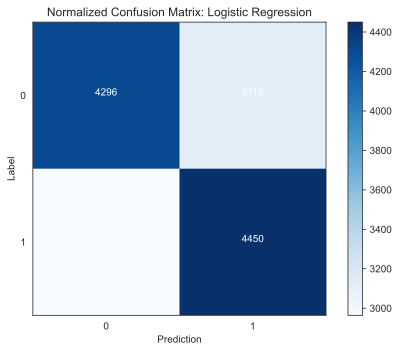

In [143]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subA, y_train) # Model for case A #
y_predict = model.predict(X_test_subA) # Label prediction with test data from case A #

# Precision for case A
precLogCasoA = round(accuracy_score(y_test, y_predict),5)

print(f'Precision {precLogCasoA}\n')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Normalized Confusion Matrix: Logistic Regression')

## Case B

Precision 0.54134

      0     1
0  3581  3833
1  2968  4446
[[3581 3833]
 [2968 4446]]


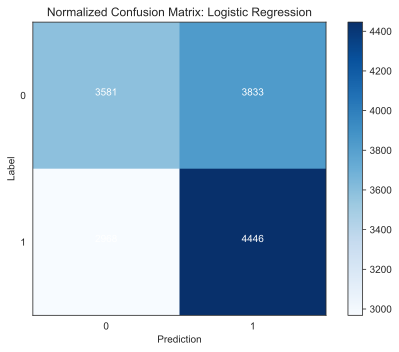

In [144]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subB, y_train) # Model for case B #
y_predict = model.predict(X_test_subB) # Label prediction with test data from case B #

# Precision for case B
precLogCasoB = round(accuracy_score(y_test, y_predict),5)

print(f'Precision {precLogCasoB}\n')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Normalized Confusion Matrix: Logistic Regression')


## Case C

Precision 0.63468

      0     1
0  4588  2826
1  2591  4823
[[4588 2826]
 [2591 4823]]


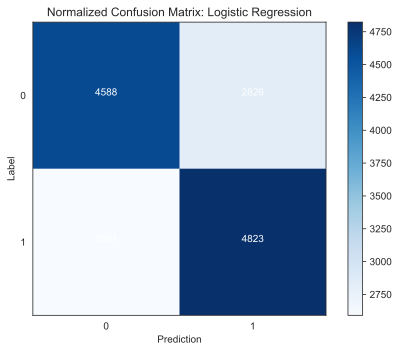

In [145]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subC, y_train) # Model for case C #
y_predict = model.predict(X_test_subC) # Label prediction with test data from case C #

# Precision for case C
precLogCasoC = round(accuracy_score(y_test, y_predict),5)

print(f'Precision {precLogCasoC}\n')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Normalized Confusion Matrix: Logistic Regression')


## Neural Network, Multilayer Perceptron

We now use the `MLPClassifier` function from the SciKit-Learn library to develop a neural network that allows improving the performance of the baseline classifier developed.

## Case A


Accuracy 0.63137
      0     1
0  4221  3193
1  2273  5141
[[4221 3193]
 [2273 5141]]


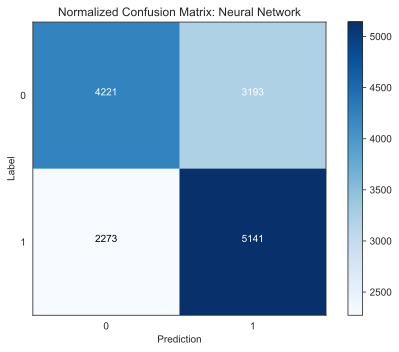

In [146]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(2, 20), activation='relu', random_state=1) # Initializes a neural network model with 2 hidden layers of 20 neurons each and ReLu activation function #
model.fit(X_train_subA, y_train) # Fits the model with data from subset A #
y_predict = model.predict(X_test_subA) # Predicts labels using test data from subset A #

# Variable to store the accuracy of case A (Neural Network)
precNNCaseA = round(accuracy_score(y_test, y_predict), 5)

print(f'Accuracy {precNNCaseA}')
print(pd.DataFrame(confusion_matrix(y_test, y_predict)))

plot_confusion_matrix(confusion_matrix(y_test, y_predict),
                      classes=class_names, 
                      title='Normalized Confusion Matrix: Neural Network')


### Caso B

Accuracy 0.62915
      0     1
0  5206  2208
1  3291  4123
[[5206 2208]
 [3291 4123]]


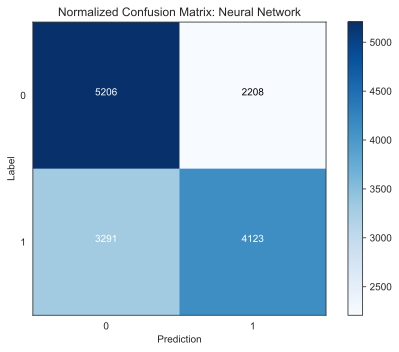

In [147]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(2, 20), activation='relu', random_state=1) # Initializes a neural network model with 2 hidden layers of 20 neurons each and ReLu activation function #
model.fit(X_train_subB, y_train) # Fits the model with data from subset B #
y_predict = model.predict(X_test_subB) # Predicts labels using test data from subset B #

# Variable to store the accuracy of case B (Neural Network)
precNNCaseB = round(accuracy_score(y_test, y_predict), 5)

print(f'Accuracy {precNNCaseB}')
print(pd.DataFrame(confusion_matrix(y_test, y_predict)))

plot_confusion_matrix(confusion_matrix(y_test, y_predict),
                      classes=class_names, 
                      title='Normalized Confusion Matrix: Neural Network')


### Caso C

Accuracy 0.68458
      0     1
0  6012  1402
1  3275  4139
[[6012 1402]
 [3275 4139]]


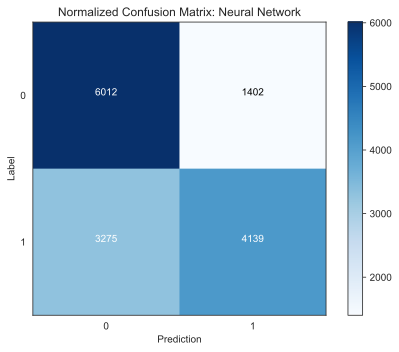

In [148]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(2, 20), activation='relu', random_state=1) # Initializes a neural network model with 2 hidden layers of 20 neurons each and ReLu activation function #
model.fit(X_train_subC, y_train) # Fits the model with data from subset C #
y_predict = model.predict(X_test_subC) # Predicts labels using test data from subset C #

# Variable to store the accuracy of case C (Neural Network)
precNNCaseC = round(accuracy_score(y_test, y_predict), 5)

print(f'Accuracy {precNNCaseC}')
print(pd.DataFrame(confusion_matrix(y_test, y_predict)))

plot_confusion_matrix(confusion_matrix(y_test, y_predict),
                      classes=class_names, 
                      title='Normalized Confusion Matrix: Neural Network')


In [149]:
# Generates a table with the accuracies of each case to see the summarized information in an organized way.
accuracies = [[precLogCasoA, precLogCasoB, precLogCasoC, precNNCaseA, precNNCaseB, precNNCaseC]]
dfAccuracies = pd.DataFrame(accuracies, columns=['Accuracy LogReg Case A', 'Accuracy LogReg Case B', 'Accuracy LogReg Case C', 'Accuracy NN Case A', 'Accuracy NN Case B', 'Accuracy NN Case C'])

dfAccuracies


,Accuracy LogReg Case A,Accuracy LogReg Case B,Accuracy LogReg Case C,Accuracy NN Case A,Accuracy NN Case B,Accuracy NN Case C
0,0.58983,0.54134,0.63468,0.63137,0.62915,0.68458


### Conclusions Part 2

The following observations can be made:

- For all three data separation cases, training the **logistic regression** model resulted in a *lower* accuracy in all cases, which is expected because this regression model is not as robust as a neural network. In fact, logistic regression can be seen as a neural network with one layer and a single sigmoid activation neuron. Comparing this to a neural network with two layers and 20 neurons in each layer, it is clear that although the neural network with 2 layers and 20 neurons per layer takes longer to train, it delivers better accuracy because it learns more with multiple neurons and layers.

- Looking only at the three cases trained with a **logistic regression** model, it can be noted that Case C, where the model was trained using all descriptor features, had the best accuracy of the three. This may be because considering all features of the model provides a better criterion for the binary classifier, thus correctly classifying more data compared to the other two cases. It can also be noted that Case A had better accuracy than Case B, which is due to the fact that in Case A, the model was trained using only the descriptors with higher IV (Information Value). With higher IV, these features are more valuable/important when classifying between classes, resulting in better classification accuracy compared to Case B, where the descriptors used have lower IV values compared to those in Case A.

- Looking only at the three cases trained with a **neural network** model with two layers and 20 neurons per layer, the same phenomenon observed with logistic regression can be noticed: accuracy is higher when only descriptors with higher IV are used compared to using descriptors with lower IV. It can also be noted that the accuracy for these two cases (cases A and B) was considerably higher than that obtained in the same cases of logistic regression, for the reasons explained in the previous item. Again, it can be observed that the accuracy for the neural network model trained using all descriptors provided the best accuracy of all cases, which may be again due to the fact that considering all descriptors of the model provides a better criterion for the binary classifier, thus correctly classifying more data compared to the other two cases.


# PART 3

The results obtained for the previous neural networks correspond only to one architecture. A necessary and important process in cases like this is hyperparameter tuning, in this case, the most suitable number of neurons (at least within a certain range, this process is also known as GridSearch).

**Split the test dataset into two halves: validation data and test data. Use the validation data to perform a preliminary evaluation of each model.** Use `train_test_split` for this part.

Use all descriptors for this test and perform the following searches:

- Case A: 1 hidden layer $\times$ {5, 10, 20, 50, 100} neurons.
- Case B: 2 hidden layers $\times$ {5, 10, 20, 50, 100} neurons.
- Case C: 3 hidden layers $\times$ {5, 10, 20, 50, 100} neurons.

Use `matplotlib.pyplot` to plot the accuracy on the validation data, select the best model, and obtain a final evaluation for this selection using the test data.

### Case A


In [150]:
# Splits the test data into two subsets: validation data and test data (version 2).
X_valid, X_test_2, y_valid, y_test_2 = train_test_split(X_test, y_test, 
                                                        stratify=y_test, test_size=0.5,
                                                        random_state=10086)

# Declares the different numbers of layers and neurons to be validated.
numLayers = [1, 2, 3]
numNeurons = [5, 10, 20, 50, 100]


[0.62234, 0.61303, 0.64621, 0.61047, 0.59725]


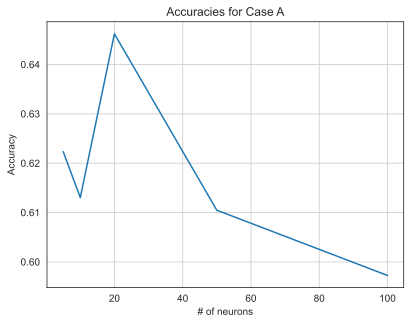

In [151]:
# List to store accuracies for case A.
accuraciesCaseA = []

# Train each model
for neurons in numNeurons:
    model = MLPClassifier(hidden_layer_sizes=(numLayers[0], neurons), activation='relu', random_state=1) 
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_valid) 
    acc = round(accuracy_score(y_valid, y_predict), 5)
    accuraciesCaseA.append(acc) # When training each possible configuration, the accuracy of the model is added to the list.

# Plot the accuracies for each requested configuration.
print(accuraciesCaseA)
plt.plot(numNeurons, accuraciesCaseA)
plt.grid()
plt.title('Accuracies for Case A')
plt.xlabel('# of neurons')
plt.ylabel('Accuracy')
plt.show()


### Case B

[0.68398, 0.67575, 0.67939, 0.67157, 0.69652]


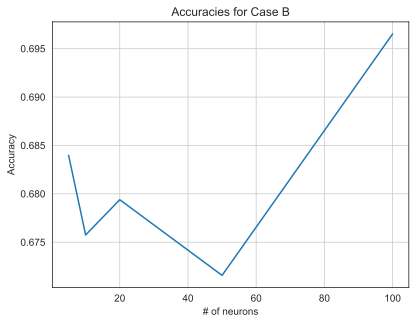

In [152]:
# List to store accuracies for case B.
accuraciesCaseB = []

# Train each model
for neurons in numNeurons:
    model = MLPClassifier(hidden_layer_sizes=(numLayers[1], neurons), activation='relu', random_state=1) 
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_valid) 
    acc = round(accuracy_score(y_valid, y_predict), 5)
    accuraciesCaseB.append(acc) # When training each possible configuration, the accuracy of the model is added to the list.

# Plot the accuracies for each requested configuration.
print(accuraciesCaseB)
plt.plot(numNeurons, accuraciesCaseB)
plt.grid()
plt.title('Accuracies for Case B')
plt.xlabel('# of neurons')
plt.ylabel('Accuracy')
plt.show()


### Case C

[0.71459, 0.71405, 0.69989, 0.70893, 0.74103]


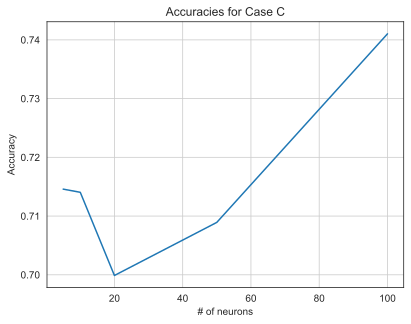

In [153]:
# List to store accuracies for case C.
accuraciesCaseC = []

# Train each model
for neurons in numNeurons:
    model = MLPClassifier(hidden_layer_sizes=(numLayers[2], neurons), activation='relu', random_state=1) 
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_valid) 
    acc = round(accuracy_score(y_valid, y_predict), 5)
    accuraciesCaseC.append(acc) # When training each possible configuration, the accuracy of the model is added to the list.

# Plot the accuracies for each requested configuration.
print(accuraciesCaseC)
plt.plot(numNeurons, accuraciesCaseC)
plt.grid()
plt.title('Accuracies for Case C')
plt.xlabel('# of neurons')
plt.ylabel('Accuracy')
plt.show()


## Now the optimal neural network configuration is determined automatically.

In [154]:
# Generates a list of the lists created previously, to then create a single list with all accuracies.
# It is known that the first 5 elements of the list correspond to case A, the next 5 to case B, and the last 5
# to case C.
list_of_lists = [accuraciesCaseA, accuraciesCaseB, accuraciesCaseC]
merged_list = list(itertools.chain.from_iterable(list_of_lists))

# Finds the highest accuracy with its respective index within the list.
best_accuracy = np.max(merged_list)
index_best_accuracy = merged_list.index(best_accuracy)

# If the index is less than or equal to 5, it means that the best accuracy occurred in case A
# and therefore, the optimal number of layers is 1. The number of optimal layers and neurons per
# layer is saved in corresponding variables.
if index_best_accuracy <= 5:
    optimal_layers = numLayers[0]
    index_best = accuraciesCaseA.index(best_accuracy)
    optimal_neurons = numNeurons[index_best]
# If the index is greater than 10, it means that the best accuracy occurred in case C
# and therefore, the optimal number of layers is 3. The number of optimal layers and neurons per
# layer is saved in corresponding variables.
elif index_best_accuracy > 10:
    optimal_layers = numLayers[2]
    index_best = accuraciesCaseC.index(best_accuracy)
    optimal_neurons = numNeurons[index_best]
# If the index is between 5 and 10, it means that the best accuracy occurred in case B
# and therefore, the optimal number of layers is 2. The number of optimal layers and neurons per
# layer is saved in corresponding variables.
else:
    optimal_layers = numLayers[1]
    index_best = accuraciesCaseB.index(best_accuracy)
    optimal_neurons = numNeurons[index_best]

# Displays the optimal results.
print(f'Optimal number of layers: {optimal_layers}')
print(f'Optimal number of neurons per layer: {optimal_neurons}')


Optimal number of layers: 3
Optimal number of neurons per layer: 100


# It was decided to choose a neural network architecture with 3 hidden layers and 10 neurons per layer because, with the validation data, the highest accuracy was obtained using this architecture.


### Evaluative Graphs


In [155]:
# Trains the model again, using the optimal numbers of layers and neurons per layer found previously,
# and tests it with the test data (version 2).
model = MLPClassifier(hidden_layer_sizes=(optimal_layers, optimal_neurons), activation='relu', random_state=1) 
model.fit(X_train, y_train) 
y_predict = model.predict(X_test_2) 
acc = round(accuracy_score(y_test_2, y_predict), 5)

# Displays the accuracy obtained with the test data (version 2).
print(f'Accuracy with optimal parameters ({optimal_layers} hidden layers, {optimal_neurons} neurons per layer): {acc}')

Accuracy with optimal parameters (3 hidden layers, 100 neurons per layer): 0.74521


      0     1
0  2183  1524
1   365  3342
[[2183 1524]
 [ 365 3342]]


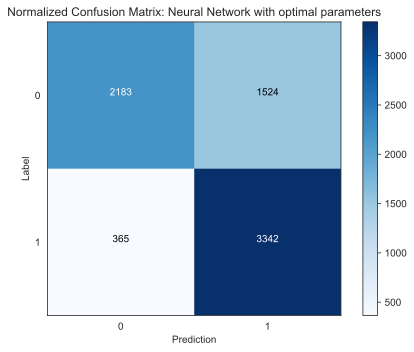

In [156]:
# Displays the confusion matrix for the model tested with the test data (version 2) and optimal parameters.
print(pd.DataFrame(confusion_matrix(y_test_2, y_predict)))

plot_confusion_matrix(confusion_matrix(y_test_2, y_predict),
                      classes=class_names, 
                      title='Normalized Confusion Matrix: Neural Network with optimal parameters')

## It was verified with the test data that the parameter selection was optimal, as a high accuracy value was obtained and the number of type 1 and type 0 errors is much lower compared to all correct classifications that the neural network provided.